# Building and Training Llama From Scratch

Kevin Putra Santoso - Avalon AI Corporation<br>
Saturday, December 21th 2024

In [17]:
from llama_modules import Transformer
from llama_modules.model import ModelArgs
import tiktoken
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import pandas as pd
from typing import Tuple

In [18]:
enc = tiktoken.get_encoding("cl100k_base")

print("Test encode - Hello world: ", enc.encode("Hello world"))
print("Test decode - Hello world: ", enc.decode(enc.encode("Hello world")))

Test encode - Hello world:  [9906, 1917]
Test decode - Hello world:  Hello world


In [19]:
# Loading data
with open('tiny_shakespeare.txt','r') as f:
    data = f.read()

token_bos = enc.encode('<|begin_of_sentence|>')[0]
token_eos = enc.encode('<|end_of_sentence|>')[0]
token_pad = enc.encode('<|pad_id|>')[0]

tensor_token_bos = torch.tensor(token_bos, dtype=torch.int, device="cuda").view(1)
tensor_token_eos = torch.tensor(token_eos, dtype=torch.int, device="cuda").view(1)
tensor_token_pad = torch.tensor(token_pad, dtype=torch.int, device="cuda").view(1)

data = enc.encode(data)

vocab = sorted(set(data))
vocab.extend([token_bos, token_eos, token_pad])
vocab_size_bpe = len(vocab)

In [20]:
itos = {i: ch for i, ch in enumerate(vocab)}
stoi = {ch: i for i, ch in enumerate(vocab)}

In [21]:
def encode(tokens):
    return [stoi[ch] for ch in tokens]

# def decode(l):
#     return ''.join(itos[i] for i in l)

def decode(l):
    return [itos[ch] for ch in l]

In [22]:
enc.decode(decode(encode(enc.encode("thou"))))

'thou'

In [23]:
params = ModelArgs(dim = 256, n_layers = 3, n_heads = 16, n_kv_heads = 4, vocab_size = vocab_size_bpe,
                   multiple_of = 128, ffn_dim_mult=1.3, norm_eps=1e-5, rope_theta = 500_000, max_seq_len=128)

model = Transformer(params).to("cuda")

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(count_parameters(model))

7285504


In [25]:
dataset = torch.tensor(encode(data), dtype=torch.int).to("cuda")
print(f"dataset-shape: {dataset.shape}")

dataset-shape: torch.Size([301829])


In [26]:
def get_dataset_batch(
    data: torch.Tensor,
    split: str,
    args: ModelArgs,
    device: str = "cuda"
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Get a batch of data for training, validation, or testing.
    
    Args:
        data: Complete dataset tensor
        split: Dataset split ("train", "val", or "test")
        args: Model arguments containing sequence length and batch size
        device: Computing device ("cuda" or "cpu")
    
    Returns:
        Tuple of (input sequences, target sequences)
    """
    # Data split ratios
    TRAIN_RATIO = 0.8
    VAL_RATIO = 0.1
    
    # Calculate split indices
    train_idx = int(TRAIN_RATIO * len(data))
    val_idx = int((TRAIN_RATIO + VAL_RATIO) * len(data))
    
    # Split data into train, validation and test sets
    splits = {
        "train": data[:train_idx],
        "val": data[train_idx:val_idx],
        "test": data[val_idx:]
    }
    
    if split not in splits:
        raise ValueError(f"Invalid split '{split}'. Must be one of: {list(splits.keys())}")
    
    batch_data = splits[split]
    seq_len = args.max_seq_len
    
    # Generate random starting indices for sequences
    indices = torch.randint(
        low=0,
        high=len(batch_data) - seq_len - 3,
        size=(args.max_batch_sz,),
        device=device
    )
    
    # Create input sequences (x) with BOS token
    x = torch.stack([
        torch.cat([tensor_token_bos, batch_data[i:i+seq_len-1]])
        for i in indices
    ]).long().to(device)
    
    # Create target sequences (y) with EOS token
    y = torch.stack([
        torch.cat([batch_data[i+1:i+seq_len], tensor_token_eos])
        for i in indices
    ]).long().to(device)
    
    return x, y

In [27]:
xs, ys = get_dataset_batch(dataset, split="train", args=params)
print(xs.shape, ys.shape)

torch.Size([32, 128]) torch.Size([32, 128])


In [12]:
device = "cuda"

@torch.no_grad()
def evaluate_loss(model, args: ModelArgs):
    out = {}
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):      
            with torch.no_grad():
                xb, yb = get_dataset_batch(dataset, split, args)
                xb, yb = xb.to(device), yb.to(device)  # Move to device, ensure detached
                _, loss = model(tokens=xb, start_pos=0, targets=yb)

            losses.append(loss.item())
        out[split] = np.mean(losses)
    return out


def train(model, optimizer, args:ModelArgs):
    epochs = 20
    log_interval = 3
    device = "cuda"
    losses = []   
    start_time = time.time()

    for epoch in range(epochs):
        # Training phase
        model.train()  # Ensure model is in training mode
        optimizer.zero_grad()  # More efficient gradient cleanup
        
        xs, ys = get_dataset_batch(dataset, 'train', args)
        xs = xs.to(device)
        ys = ys.to(device)
        
        # Get loss and do backward pass
        _, loss = model(tokens=xs, start_pos=0, targets=ys)
        loss.backward(retain_graph=True)
        optimizer.step()

        # Evaluation phase
        if epoch % log_interval == 0:
            torch.cuda.empty_cache()  # Clear GPU memory
            batch_time = time.time() - start_time
            with torch.no_grad():
                x = evaluate_loss(model, args)
            losses.append(x)            
            print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f}")
            start_time = time.time()
        
    return pd.DataFrame(losses).plot()

Epoch 0 | val loss 9.575 | Time 0.481
Epoch 3 | val loss 9.553 | Time 0.159
Epoch 6 | val loss 9.536 | Time 0.164
Epoch 9 | val loss 9.511 | Time 0.145
Epoch 12 | val loss 9.487 | Time 0.159
Epoch 15 | val loss 9.449 | Time 0.153
Epoch 18 | val loss 9.409 | Time 0.148


<Axes: >

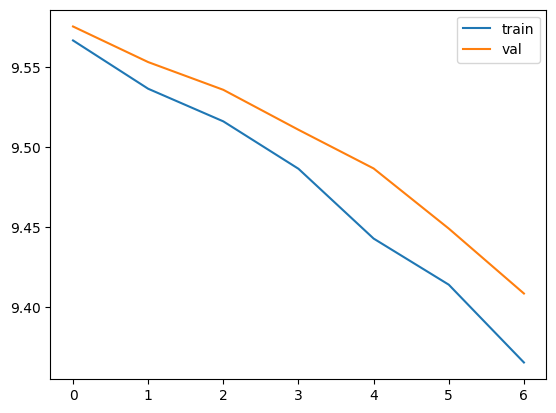

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train(model, optimizer, params)

## Proses Inferensi akan dilanjutkan pada Part 2